<a href="https://colab.research.google.com/github/YttriLab/B-SOID/blob/master/googlecolab/bsoid_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title B-SOiD GOOGLE COLAB 
# Created by Yttri Lab at Carnegie Mellon University.
# Program developer: Alexander Hsu.
# Program collaborator: Vishal Patel.
# Date last modified: 041020
# Contact: ahsu2@andrew.cmu.edu

# Import necessary python packages
import numpy as np
import math
import pandas as pd
import time
import glob
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import mixture, svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Defining a few functions. 

In [0]:
#@title BOXCAR_CENTER
def boxcar_center(a, n):

  a1 = pd.Series(a)
  moving_avg = np.array(a1.rolling(window = n,min_periods=1,center = True).mean())
  
  return moving_avg 

In [0]:
#@title ADP_FILT
def adp_filt(currDf=None,*args,**kwargs):

    lIndex = []
    xIndex = []
    yIndex = []
    currDf = np.array(currDf[1:])
    for header in range(len(currDf[0])):
        if currDf[0][header] == "likelihood":
            lIndex.append(header)
        elif currDf[0][header] == "x":
            xIndex.append(header)
        elif currDf[0][header] == "y":
            yIndex.append(header)
    print('Replacing data-driven low likelihood positions with the most recent highly probable position... \n')
    start_time = time.time()
    currDf = np.array(currDf)
    currDf1 = currDf[:,1:]
    datax=currDf1[:,np.array(xIndex)-1]
    datay=currDf1[:,np.array(yIndex)-1]
    data_lh=currDf1[:,np.array(lIndex)-1]
    currDf_filt = np.zeros((datax.shape[0]-1,(datax.shape[1])*2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in range(data_lh.shape[1]):
        if x <= 2:
            a,b = np.histogram(data_lh[1:,x].astype(np.float))
            rise_a = np.where(np.diff(a) >= 0)
            if rise_a[0][0] > 1:
                llh = (b[rise_a[0][0]]+b[rise_a[0][0]-1])/2
            else:
                llh = (b[rise_a[0][1]]+b[rise_a[0][1]-1])/2
        else:
            llh = 0.2
        data_lh_float = data_lh[1:,x].astype(np.float)
        perc_rect[x] = len(np.where(data_lh_float < llh)) / data_lh.shape[1]
        currDf_filt[0,(2*x):(2*x + 2)] = np.hstack([datax[1,x],datay[1,x]])
        # replacing with most recent highly probable positions
        for i in range(1,data_lh.shape[0]-1):
            if data_lh_float[i] < llh:
                currDf_filt[i,(2*x):(2*x + 2)] = currDf_filt[i - 1,(2*x):(2*x + 2)]
            else:
                currDf_filt[i,(2*x):(2*x + 2)] = np.hstack([datax[i,x],datay[i,x]])
    currDf_filt = np.array(currDf_filt[1:])
    currDf_filt = currDf_filt.astype(np.float)
    print("--- High-pass filter took %s seconds ---" % (time.time() - start_time))
    
    return currDf_filt, perc_rect

In [0]:
#@title B-SOiD_ASSIGN { vertical-output: true, display-mode: "form" }

def bsoid_assign(data,fps,comp,kclass,it,*args,**kwargs):
    
    win_len = np.int(np.round(0.05/(1/fps))*2-1)
    print('Obtaining features from dataset... \n')
    start_time = time.time()
    feats = list()
    for m in range(len(data)):
        ## Obtain features, 4 distance features and 3 time-varying speed/angle features
        dataRange = len(data[m])
        fpd = data[m][:,2:4] - data[m][:,4:6]
        cfp = np.vstack(((data[m][:,2]+data[m][:,4])/2,(data[m][:,3]+data[m][:,5])/2)).T
        cfpLen = len(cfp)
        cfp_pt = np.vstack(([cfp[:,0]-data[m][:,10],cfp[:,1]-data[m][:,11]])).T
        chp = np.vstack((((data[m][:,6]+data[m][:,8])/2),((data[m][:,7]+data[m][:,9])/2))).T
        chp_pt = np.vstack(([chp[:,0] - data[m][:,10],chp[:,1] - data[m][:,11]])).T
        sn_pt = np.vstack(([data[m][:,0] - data[m][:,10],data[m][:,1] - data[m][:,11]])).T
        fpd_norm = np.zeros(dataRange)
        cfp_pt_norm = np.zeros(dataRange)
        chp_pt_norm = np.zeros(dataRange)
        sn_pt_norm = np.zeros(dataRange)
        fpd_norm_smth = np.zeros(dataRange)
        sn_cfp_norm_smth = np.zeros(dataRange)
        sn_chp_norm_smth = np.zeros(dataRange)
        sn_pt_norm_smth = np.zeros(dataRange)
        for i in range(1,dataRange):
            fpd_norm[i] = np.array(np.linalg.norm(data[m][i,2:4] - data[m][i,4:6]))
            cfp_pt_norm[i] = np.linalg.norm(cfp_pt[i,:])
            chp_pt_norm[i] = np.linalg.norm(chp_pt[i,:])
            sn_pt_norm[i] = np.linalg.norm(sn_pt[i,:])
        fpd_norm_smth = boxcar_center(fpd_norm,win_len)
        sn_cfp_norm_smth = boxcar_center(sn_pt_norm- cfp_pt_norm,win_len)
        sn_chp_norm_smth = boxcar_center(sn_pt_norm - chp_pt_norm,win_len)
        sn_pt_norm_smth = boxcar_center(sn_pt_norm,win_len)
        sn_pt_ang = np.zeros(dataRange-1)
        sn_disp = np.zeros(dataRange-1)
        pt_disp = np.zeros(dataRange-1)
        sn_pt_ang_smth = np.zeros(dataRange-1)
        sn_disp_smth = np.zeros(dataRange-1)
        pt_disp_smth = np.zeros(dataRange-1)
        for k in range(0,dataRange - 1):
            b_3d = np.hstack([sn_pt[k + 1,:],0])
            a_3d = np.hstack([sn_pt[k,:],0])
            c = np.cross(b_3d,a_3d)
            sn_pt_ang[k] = np.dot(np.dot(np.sign(c[2]),180)/np.pi , math.atan2(np.linalg.norm(c),np.dot(sn_pt[k,:],sn_pt[k + 1,:])))
            sn_disp[k] = np.linalg.norm(data[m][k + 1,0:2] - data[m][k,0:2])
            pt_disp[k] = np.linalg.norm(data[m][k + 1,10:12] - data[m][k,10:12])
        sn_pt_ang_smth=boxcar_center(sn_pt_ang,win_len)
        sn_disp_smth=boxcar_center(sn_disp,win_len)
        pt_disp_smth=boxcar_center(pt_disp,win_len)
        feats.append(np.vstack((sn_cfp_norm_smth[1:],sn_chp_norm_smth[1:],fpd_norm_smth[1:],
                                        sn_pt_norm_smth[1:],sn_pt_ang_smth[:],sn_disp_smth[:],pt_disp_smth[:])))
    print("--- Feature extraction took %s seconds ---" % (time.time() - start_time))  
    #Feature compilation
    start_time = time.time()
    if comp == 0:
      f_10fps = list()
      tsne_feats = list()
      labels = list()   
    for n in range(0,len(feats)):
      feats1 = np.zeros(len(data[n]))
      for k in range(round(fps / 10)-1,len(feats[n][0]),round(fps / 10)):
        if k > round(fps/10)-1:
          feats1 = np.concatenate((feats1.reshape(feats1.shape[0],feats1.shape[1]),
                                  np.hstack((np.mean((feats[n][0:4,range(k - round(fps / 10),k)]), axis = 1),
                                              np.sum((feats[n][4:7,range(k - round(fps / 10),k)]), axis = 1))).reshape(len(feats[0]),1)),axis = 1)
        else:
          feats1 = np.hstack((np.mean((feats[n][0:4,range(k - round(fps / 10),k)]), axis = 1),
                              np.sum((feats[n][4:7,range(k - round(fps / 10),k)]), axis = 1))).reshape(len(feats[0]),1)
      print("--- Feature compilation took %s seconds ---" % (time.time() - start_time))
      if comp == 1:
        if n > 0:
          f_10fps = np.concatenate((f_10fps,feats1),axis = 1)
        else:
          f_10fps = feats1
      else:
        feats1_norm = feats1.T/np.std(feats1,axis=1)
        f_10fps.append(feats1_norm)
        if len(f_10fps[n]) < 15000:
          p = 50
          exag = 4
          lr = 500
        else:
          p = round(f_10fps[n].shape[1]/300)
          exag = round(f_10fps[n].shape[1]/2500)
          lr = round(np.log(f_10fps[n].shape[1])/0.02)
        start_time = time.time()
        ## Run t-SNE dimensionality reduction
        np.random.seed(0) # For reproducibility
        print('Running the compiled data through t-SNE collapsing the 7 features onto 3 action space coordinates... \n')
        tsne_feats_i =TSNE(n_components=3,perplexity=p, early_exaggeration=exag, learning_rate=lr, n_jobs=8).fit_transform(f_10fps[n].T)
        tsne_feats.append(tsne_feats_i)
        print("--- TSNE embedding took %s seconds ---" % (time.time() - start_time))

        ## Run a Gaussian Mixture Model Expectation Maximization to group the t-SNE clusters
        start_time = time.time()
        gmm = mixture.GaussianMixture(n_components=kclass, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=it, init_params='random').fit(tsne_feats_i)
        grp = gmm.predict(tsne_feats_i)
        labels.append(grp)
        print("--- Gaussian mixtures took %s seconds ---" % (time.time() - start_time))
        print(" Plotting t-SNE with GMM assignments... ")
        uk = list(np.unique(labels))
        uniqueLabels = []
        for i in labels:
          indexVal = uk.index(i)
          uniqueLabels.append(indexVal)
        R = np.linspace(0,1,len(uk))
        color=plt.cm.hsv(R)
        fig = go.Figure(data=[go.Scatter3d(x=tsne_feats_i[:,0], y=tsne_feats_i[:,1], z=tsne_feats_i[:,2], mode='markers', 
                                     marker=dict(size=2.5, color=color[uniqueLabels], opacity=0.8))])
        fig.show()
        print('TADA! \n')
    if comp == 1:
        if len(f_10fps) < 15000:
          p = 50
          exag = 4
          lr = 500
        else:
          p = round(f_10fps.shape[1]/300)
          exag = round(f_10fps.shape[1]/2500)
          lr = round(np.log(f_10fps.shape[1])/0.02)
        f_10fps_norm = f_10fps.T/np.std(f_10fps,axis=1)
        start_time = time.time()
        ## Run t-SNE dimensionality reduction
        np.random.seed(0) # For reproducibility
        print('Running the compiled data through t-SNE collapsing the 7 features onto 3 action space coordinates... \n')
        tsne_feats=TSNE(n_components=3,perplexity=p, early_exaggeration=exag, learning_rate=lr, n_jobs=8).fit_transform(f_10fps_norm)
        print("--- TSNE embedding took %s seconds ---" % (time.time() - start_time))
        ## Run a Gaussian Mixture Model Expectation Maximization to group the t-SNE clusters
        start_time = time.time()
        gmm = mixture.GaussianMixture(n_components=kclass, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=it, init_params='random').fit(tsne_feats)
        labels = gmm.predict(tsne_feats)
        print("--- Gaussian mixtures took %s seconds ---" % (time.time() - start_time))
        print(" Plotting t-SNE with GMM assignments... ")
        uk = list(np.unique(labels))
        uniqueLabels = []
        for i in labels:
          indexVal = uk.index(i)
          uniqueLabels.append(indexVal)
        R = np.linspace(0,1,len(uk))
        color=plt.cm.hsv(R)
        fig = go.Figure(data=[go.Scatter3d(x=tsne_feats[:,0], y=tsne_feats[:,1], z=tsne_feats[:,2], mode='markers', 
                                     marker=dict(size=2.5, color=color[uniqueLabels], opacity=0.8))])
        fig.show()
        print('TADA! \n')

    return f_10fps,tsne_feats,np.array(uniqueLabels),fig

In [0]:
#@title B-SOiD_MDL2
def bsoid_mdl2(f_10fps=None,labels=None,hldout=None,cv_it=None,*args,**kwargs):   
    
    print('Parsing features into train and test sets')
    feats_T=f_10fps.T
    labels_T=labels.T
    np.random.seed(0)
    feats_train, feats_test, labels_train, labels_test = train_test_split(feats_T, labels_T, test_size=hldout, 
                                                                          random_state=0)
    start_time = time.time()
    print('Training an SVM classifier (kernel trick: Gaussian)... \n')
    clf = svm.SVC(gamma=0.005, C= 10, random_state=0)
    clf.fit(feats_train, labels_train)
    scores = cross_val_score(clf, feats_test, labels_test, cv=cv_it)
    print("--- Training classifier and performing cross-validation {} times took %s seconds ---".format(cv_it) % (time.time() - start_time))
    fig = plt.figure(num=None, figsize=(1.5, 2), dpi=300, facecolor='w', edgecolor='k')
    fig.suptitle("Performance on {} % Data".format(hldout*100), fontsize=8, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.boxplot(scores, notch=None)
    ax.set_xlabel('SVM',fontsize=8)
    ax.set_ylabel('Accuracy',fontsize=8)
    
    return clf,fig,scores

# Load your pose estimate data (.csv) generated from either [DeepLabCut](https://github.com/AlexEMG/DeepLabCut) or [LEAP](https://github.com/talmo/leap).

In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Load your data
# Step 1: change path to "/content/drive/My Drive/DeepLabCut/"
# Step 2: change datelist to ["experiment1","experiment2","more"]
path = "/content/drive/My Drive/Colab Notebooks/"
datelist = ["041919","042219"] # get the folder name
all_files = list()
print('Compiling all files...')
for dates in datelist:
    for file in glob.glob(path + dates + "/*.csv"):
        all_files.append(file)
li = []
li_filt = []
perc_rect_li = []
print('High-pass filter for low-likelihood pose estimation:')
for filename in all_files:
    currDf = pd.read_csv(filename,low_memory=False)
    currDf_filt,perc_rect = adp_filt(currDf)
    li.append(currDf)
    perc_rect_li.append(perc_rect)
    li_filt.append(currDf_filt)
data = np.array(li_filt)
print('You have compiled .csv files into a',data.shape,'data list.')
data = data

Compiling all files...
High-pass filter for low-likelihood pose estimation:
Replacing data-driven low likelihood positions with the most recent highly probable position... 

--- High-pass filter took 7.754404067993164 seconds ---
Replacing data-driven low likelihood positions with the most recent highly probable position... 

--- High-pass filter took 8.009180307388306 seconds ---
Replacing data-driven low likelihood positions with the most recent highly probable position... 

--- High-pass filter took 8.02735710144043 seconds ---
Replacing data-driven low likelihood positions with the most recent highly probable position... 

--- High-pass filter took 8.136563062667847 seconds ---
You have compiled .csv files into a (4, 107999, 12) data list.


# Feature extraction, dimensionality reduction (t-SNE), and pattern recognition (EM-GMM). **Change fps = camera frame-rate.**![Schematic](https://drive.google.com/uc?id=1_74Bdw8NThaMPj5r66uRMxMKpHz3aP2A)

In [0]:
# change fps = camera frame-rate
f_10fps,tsne_feats,labels,tsne_fig = bsoid_assign(data,fps = 60,comp = 1,kclass = 50,it = 30) 

Obtaining features from dataset... 

--- Feature extraction took 50.83459544181824 seconds ---
--- Feature compilation took 2.7088942527770996 seconds ---
--- Feature compilation took 5.37028431892395 seconds ---
--- Feature compilation took 8.043020486831665 seconds ---
--- Feature compilation took 10.734505891799927 seconds ---
Running the compiled data through t-SNE collapsing the 7 features onto 3 action space coordinates... 

--- TSNE embedding took 1195.2633850574493 seconds ---
--- Gaussian mixtures took 52.08018398284912 seconds ---
 Plotting t-SNE with GMM assignments... 


TADA! 



# Train a multiclass support vector machine (One vs. rest, kernel = Gaussian) classifier using pose as input, and clustered group as label. **Change hldout if you desire a different train/test ratio; change cv_it < 30 if you have a small dataset.**![Schematic](https://drive.google.com/uc?id=1AWcy4BOJ-h3obBEgEGjXyCkhI105MdTJ)

Parsing features into train and test sets
Training an SVM classifier (kernel trick: Gaussian)... 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 26 members, which is less than n_splits=30.



--- Training classifier and performing cross-validation 30 times took 311.1580331325531 seconds ---


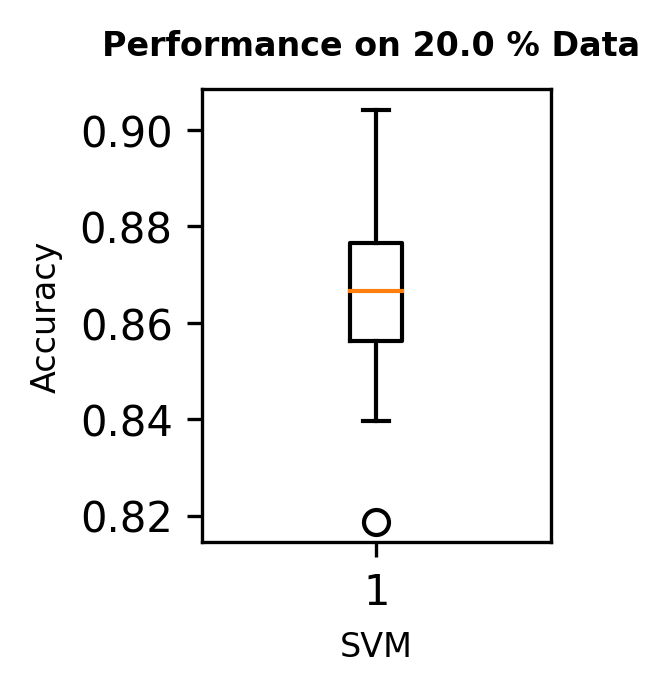

In [0]:
# change hldout if you desire a different train/test ratio; change cv_it < 30 if you have a small dataset
clf,acc_fig,scores = bsoid_mdl2(f_10fps=f_10fps,labels=labels,hldout=0.2,cv_it=30) 

In [0]:
print(np.unique(labels),np.mean(scores))
print(all_files)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 0.865
['/content/drive/My Drive/Colab Notebooks/041919/2019-04-19_09-34-36cut0_30minDeepCut_resnet50_OpenFieldHighResApr8shuffle1_1030000.csv', '/content/drive/My Drive/Colab Notebooks/041919/2019-04-19_09-34-36cut30min_1hrDeepCut_resnet50_OpenFieldHighResApr8shuffle1_1030000.csv', '/content/drive/My Drive/Colab Notebooks/042219/2019-04-22_12-00-37cut30min_1hrDeepCut_resnet50_OpenFieldHighResApr8shuffle1_1030000.csv', '/content/drive/My Drive/Colab Notebooks/042219/2019-04-22_12-00-37cut0_30minDeepCut_resnet50_OpenFieldHighResApr8shuffle1_1030000.csv']


# Plot multi-feature distributions (histograms by group).

<Figure size 600x900 with 0 Axes>

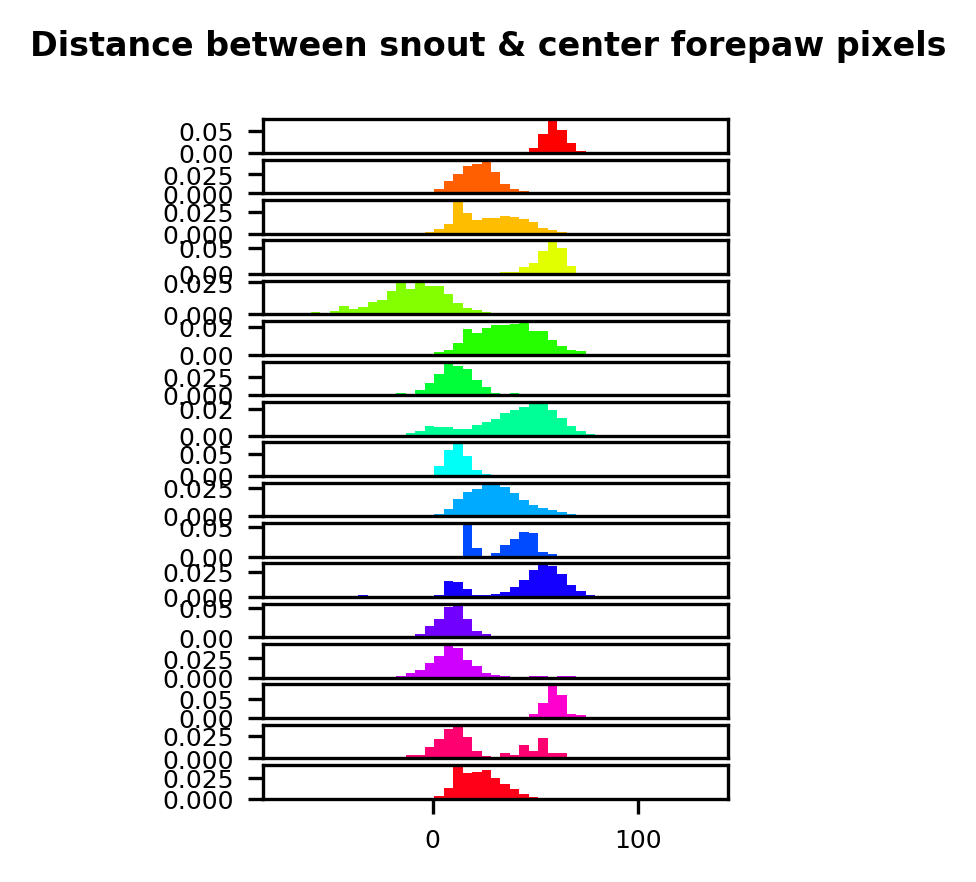

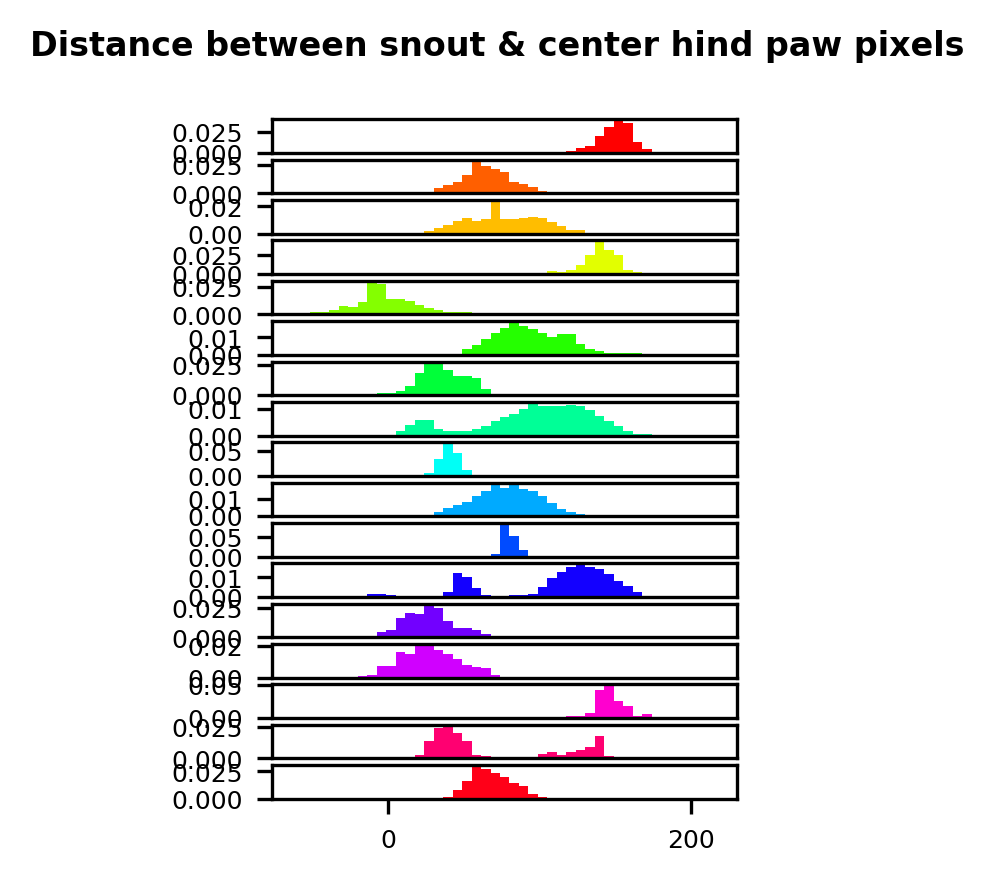

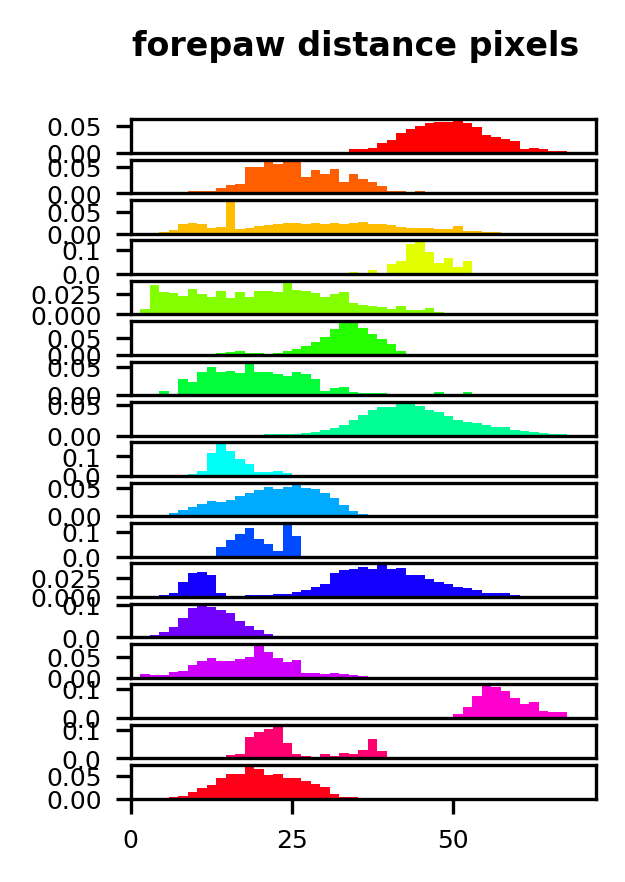

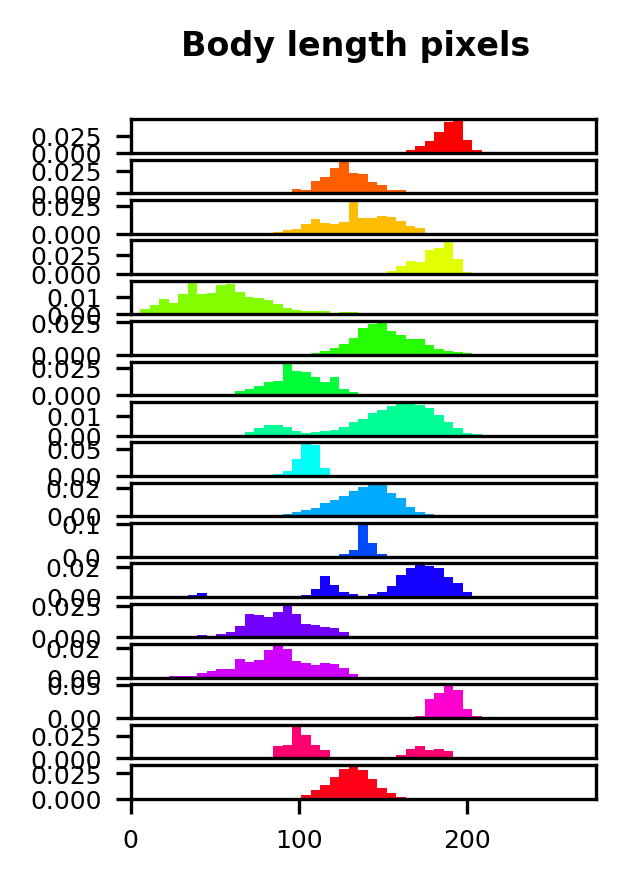

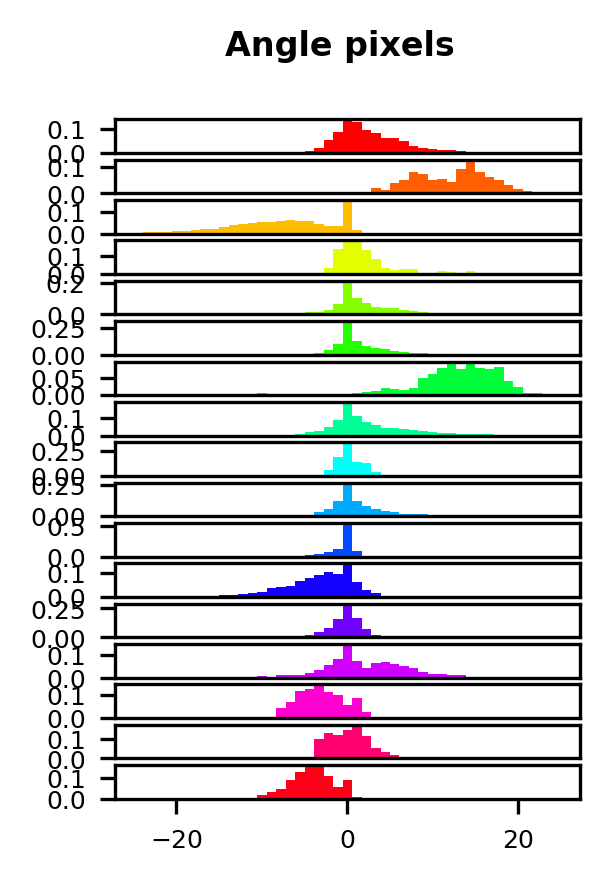

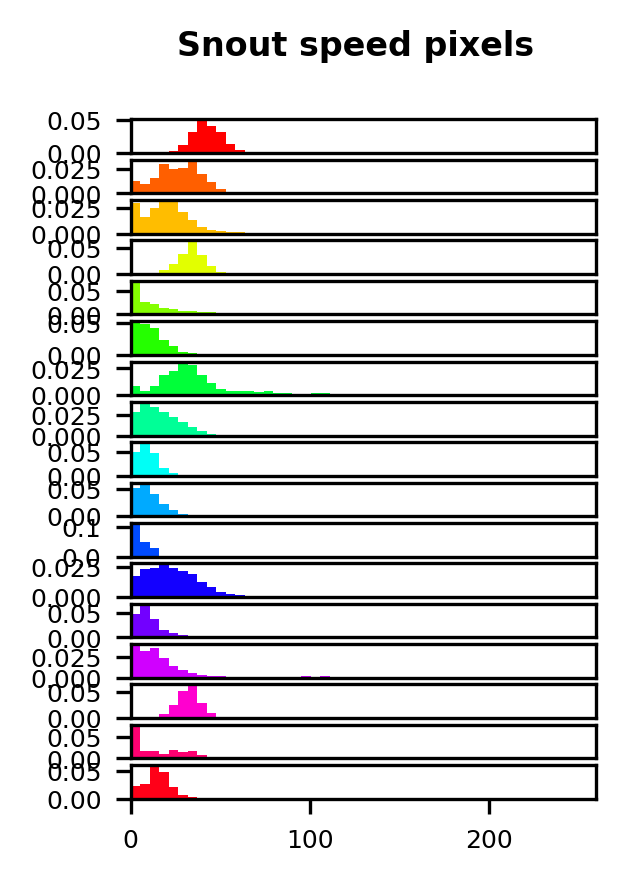

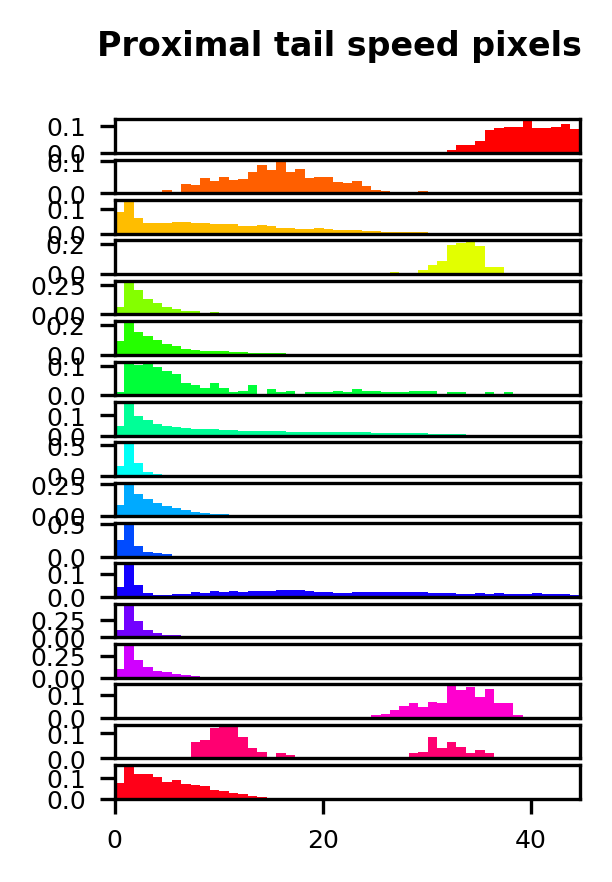

In [0]:
fig = plt.figure(num=None, figsize=(2, 3), dpi=300, facecolor='w', edgecolor='k')
R = np.linspace(0,1,len(np.unique(labels)))
color=plt.cm.hsv(R)
feat_ls = ("Distance between snout & center forepaw","Distance between snout & center hind paw","forepaw distance",
              "Body length","Angle","Snout speed","Proximal tail speed")
for j in range(0,f_10fps.shape[0]):
  fig = plt.figure(num=None, figsize=(2, 3), dpi=300, facecolor='w', edgecolor='k')
  for i in range(0,len(np.unique(labels))):
    plt.subplot(len(np.unique(labels)), 1, i+1)
    if j == 2 or j == 3 or j == 5 or j == 6:
      plt.hist(f_10fps[j,labels == i],
              bins = np.linspace(0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              range = (0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              color = color[i], density=True)
      plt.xticks(fontsize=6)
      plt.yticks(fontsize=6)
      fig.suptitle("{} pixels".format(feat_ls[j]), fontsize=8, fontweight='bold')
      plt.xlim(0,np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:]))
      if i < len(np.unique(labels))-1:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
      plt.hist(f_10fps[j,labels == i],
              bins = np.linspace(np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              range = (np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:])),
              color = color[i], density=True)
      plt.xticks(fontsize=6)
      plt.yticks(fontsize=6)
      plt.xlim(np.mean(f_10fps[j,:])-3*np.std(f_10fps[j,:]),np.mean(f_10fps[j,:])+3*np.std(f_10fps[j,:]))
      fig.suptitle("{} pixels".format(feat_ls[j]), fontsize=8, fontweight='bold')
      if i < len(np.unique(labels))-1:
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()